# Recommender System -- LFM

In [5]:
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
np.random.seed(100)

## Data preprocess
https://grouplens.org/datasets/movielens/

In [6]:
df = pd.read_csv('./data/ratings.dat', sep='::', header=None, engine='python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
df.shape

(1000209, 4)

In [8]:
all_user_cnt = len(df.user_id.unique())
all_user_cnt

6040

In [9]:
all_movies = set(df.movie_id.unique())
all_movie_cnt = len(all_movies)
all_movie_cnt

3706

### Train test slipt

In [10]:
X, y = df[['user_id', 'movie_id']].values, df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/8, random_state=0)

In [11]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(875182, 2) (875182,) (125027, 2) (125027,)


In [12]:
movie_popularity = defaultdict(int)
for _, m_id in X_train:
    movie_popularity[m_id] += 1

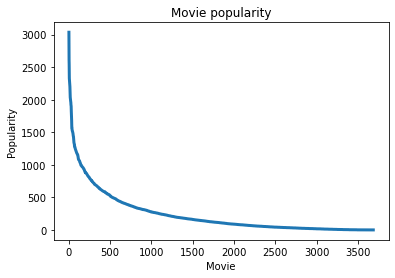

In [13]:
sorted_movie_popularity = sorted(movie_popularity.items(), key=lambda x: x[1], reverse=True)
plt.plot(list(map(lambda x: x[1], sorted_movie_popularity)), linewidth=3)
plt.title('Movie popularity')
plt.ylabel('Popularity')
plt.xlabel('Movie')
plt.show()

## LFM
Just consider the interaction but not rating

In [14]:
# 统计User交互过的Movie，存储为Set
def get_user_movies(data):
    user_movies = defaultdict(set)
    for u_id, m_id in data:
        user_movies[u_id].add(m_id)
    return user_movies

In [15]:
user_movies_train = get_user_movies(X_train)
user_movies_test = get_user_movies(X_test)

### LFM

In [18]:
class LatentFactorModel:
    def __init__(self, K, alpha, beta, ratio):
        self.K = K  # Latent vector size
        self.alpha = alpha  # learning ratio
        self.beta = beta  # regularization factor
        self.ratio = ratio  # negetive sample/positive sample
        self.P = {}
        self.Q = {}
    
    def init_model(self, user_movies):
        for u_id, u_movies in user_movies.items():
            if u_id not in self.P:
                self.P[u_id] = np.random.rand(self.K)
            for m_id in u_movies:
                if m_id not in self.Q:
                    self.Q[m_id] = np.random.rand(self.K)
    
    def calc_loss(self, user_movies, movie_popularity):
        loss = 0
        for u_id, u_movies in user_movies.items():
            data = self.sample_data(u_id, u_movies, movie_popularity)
            for u_id, m_id, rui in data:
                loss += np.square(rui - np.dot(self.P[u_id], self.Q[m_id])) + self.beta * np.sum(np.square(self.P[u_id]) + np.square(self.Q[m_id]))
        return loss / len(user_movies)
    
    def sample_data(self, u_id, u_movies, movie_popularity):
        all_movies = set(movie_popularity.keys())
        pos_movies = u_movies
        # negetive sample
        all_neg_movies = list(all_movies - pos_movies)
        neg_movies = np.random.choice(all_neg_movies, size=int(self.ratio * len(pos_movies)), replace=True, p=None)
        
        # generate data
        data = []
        for m_id in pos_movies:
            data.append((u_id, m_id, 1))
        for m_id in neg_movies:
            data.append((u_id, m_id, 0))
        np.random.shuffle(data)
        return data
    
    def train(self, user_movies, movie_popularity, epoch):
        self.init_model(user_movies)
        alpha = self.alpha
        for t in range(epoch):
            for u_id, u_movies in tqdm(user_movies.items()):
                data = self.sample_data(u_id, u_movies, movie_popularity)
                for u_id, m_id, rui in data:
                    eui = rui - np.dot(self.P[u_id], self.Q[m_id])
                    self.P[u_id] += alpha * (eui * self.Q[m_id] - self.beta * self.P[u_id])
                    self.Q[m_id] += alpha * (eui * self.P[u_id] - self.beta * self.Q[m_id])
            alpha *= 0.9
            #print('epoch:{}, lr:{}, loss:{}'.format(t, alpha, self.calc_loss(user_movies, movie_popularity)))
            print('epoch:{}, lr:{}'.format(t, alpha))
    
    def recommend(self, u_id, user_movies):
        res = defaultdict(float)
        u_movies = user_movies[u_id]
        u_vec = self.P[u_id]
        for m_id in self.Q:
            if m_id not in u_movies:
                m_vec = self.Q[m_id]
                res[m_id] = np.dot(u_vec, m_vec)
        return list(map(lambda x: x[0], sorted(res.items(), key=lambda x: x[1], reverse=True)))

## Evaluate

In [19]:
# precision, recall, coverage
def calc_metrics(user_movies, user_movies_reco, all_movie_cnt, n=None):
    label_all, reco_all, hit = 0, 0, 0
    all_movies_reco = []
    for u_id in user_movies:
        label_movies = user_movies[u_id]
        reco_movies = user_movies_reco[u_id][:n] if n else user_movies_reco[u_id]
        all_movies_reco += reco_movies
        reco_movies = set(reco_movies)
        label_all += len(label_movies)
        reco_all += len(reco_movies)
        hit += len(label_movies & reco_movies)
    return {
        'precision': hit / reco_all,
        'recall': hit / label_all,
        'coverage': len(set(all_movies_reco)) / all_movie_cnt
    }

In [20]:
model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=10)
model.train(user_movies_train, movie_popularity, 20)
# recommend
user_movies_reco = {}
for u_id in user_movies_test:
    user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)
# evaluate
calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

  0%|          | 4/6040 [00:00<02:48, 35.81it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<02:36, 38.55it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:42, 37.14it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 4/6040 [00:00<02:40, 37.52it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:38, 38.19it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<03:21, 29.93it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:39, 37.93it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<02:56, 34.27it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:38, 38.20it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 6/6040 [00:00<05:08, 19.55it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<02:41, 37.40it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<02:46, 36.15it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<03:07, 32.17it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 5/6040 [00:00<03:12, 31.33it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 4/6040 [00:00<02:38, 38.19it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<03:01, 33.25it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<02:54, 34.57it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<03:26, 29.27it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 4/6040 [00:00<02:38, 38.20it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [02:28<00:00, 40.62it/s] 


epoch:19, lr:0.002431533091811388


{'precision': 0.26579429904984164,
 'recall': 0.12753245299015412,
 'coverage': 0.18213707501349163}

### different ratio

In [15]:
ratio_list = [1.0, 2.0, 5.0, 10.0, 20.0]
metrics_ratio = {}

for ratio in ratio_list:
    model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=ratio)
    model.train(user_movies_train, movie_popularity, 20)
    # recommend
    user_movies_reco = {}
    for u_id in user_movies_test:
        user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)
    # evaluate
    metrics_ratio[ratio] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

pd.DataFrame(metrics_ratio)

  0%|          | 10/6040 [00:00<01:04, 93.92it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 10/6040 [00:00<01:05, 91.47it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 10/6040 [00:00<01:05, 92.52it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 23/6040 [00:00<00:58, 103.64it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 23/6040 [00:00<00:57, 103.88it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 22/6040 [00:00<00:57, 104.02it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 10/6040 [00:00<01:07, 89.88it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 10/6040 [00:00<01:03, 94.82it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 22/6040 [00:00<01:00, 99.20it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 23/6040 [00:00<00:59, 101.14it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 10/6040 [00:00<01:03, 94.86it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 10/6040 [00:00<01:04, 93.16it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 10/6040 [00:00<01:06, 90.43it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 10/6040 [00:00<01:04, 93.71it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 10/6040 [00:00<01:04, 93.29it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 10/6040 [00:00<01:02, 97.13it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 23/6040 [00:00<00:59, 101.46it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 10/6040 [00:00<01:04, 93.75it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 11/6040 [00:00<00:58, 102.85it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [00:26<00:00, 229.30it/s]


epoch:19, lr:0.002431533091811388


  0%|          | 7/6040 [00:00<01:34, 63.76it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 7/6040 [00:00<01:43, 58.12it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 7/6040 [00:00<01:42, 59.12it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 7/6040 [00:00<01:46, 56.53it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 7/6040 [00:00<01:28, 68.45it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 7/6040 [00:00<01:38, 61.13it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 15/6040 [00:00<01:32, 65.09it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 8/6040 [00:00<01:16, 78.58it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 7/6040 [00:00<01:32, 65.26it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 16/6040 [00:00<01:22, 73.42it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 7/6040 [00:00<01:37, 61.57it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 15/6040 [00:00<01:23, 72.05it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 7/6040 [00:00<01:37, 61.88it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 15/6040 [00:00<01:30, 66.90it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 7/6040 [00:00<01:36, 62.53it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 15/6040 [00:00<01:31, 65.80it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 15/6040 [00:00<01:31, 65.93it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 15/6040 [00:00<01:32, 65.45it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 15/6040 [00:00<01:25, 70.49it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [00:37<00:00, 161.24it/s]


epoch:19, lr:0.002431533091811388


  0%|          | 5/6040 [00:00<02:00, 49.92it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 5/6040 [00:00<02:02, 49.36it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 7/6040 [00:00<03:28, 28.90it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 7/6040 [00:00<03:12, 31.36it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 5/6040 [00:00<02:09, 46.45it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 7/6040 [00:00<03:13, 31.15it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 5/6040 [00:00<02:02, 49.15it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 5/6040 [00:00<02:13, 45.04it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 5/6040 [00:00<02:02, 49.10it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 5/6040 [00:00<02:06, 47.78it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 5/6040 [00:00<02:04, 48.46it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 7/6040 [00:00<03:17, 30.52it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 7/6040 [00:00<03:15, 30.89it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 5/6040 [00:00<02:01, 49.56it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 5/6040 [00:00<02:02, 49.07it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 5/6040 [00:00<02:14, 45.01it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 7/6040 [00:00<03:13, 31.21it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 10/6040 [00:00<02:50, 35.35it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 5/6040 [00:00<02:02, 49.31it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [01:14<00:00, 80.99it/s] 


epoch:19, lr:0.002431533091811388


  0%|          | 4/6040 [00:00<03:06, 32.40it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<02:50, 35.50it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:55, 34.34it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 6/6040 [00:00<04:37, 21.72it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:52, 35.05it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<03:06, 32.33it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:52, 34.91it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<02:55, 34.33it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:49, 35.66it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 4/6040 [00:00<02:48, 35.91it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<03:05, 32.51it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<03:09, 31.84it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<03:02, 33.16it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 4/6040 [00:00<02:50, 35.45it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 6/6040 [00:00<04:31, 22.21it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<02:47, 36.11it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<02:52, 34.96it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<03:03, 32.84it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 6/6040 [00:00<04:53, 20.56it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [02:13<00:00, 45.18it/s] 


epoch:19, lr:0.002431533091811388


  0%|          | 2/6040 [00:00<06:17, 16.01it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<05:17, 18.98it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 2/6040 [00:00<05:38, 17.82it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 2/6040 [00:00<05:49, 17.29it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 2/6040 [00:00<05:46, 17.45it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 2/6040 [00:00<05:17, 19.04it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<05:20, 18.85it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 2/6040 [00:00<05:44, 17.51it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<05:18, 18.96it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 2/6040 [00:00<05:48, 17.34it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 2/6040 [00:00<05:18, 18.93it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<05:18, 18.97it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<05:16, 19.07it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 2/6040 [00:00<05:27, 18.46it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 2/6040 [00:00<06:14, 16.12it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<05:23, 18.66it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<05:27, 18.43it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 2/6040 [00:00<05:45, 17.48it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 2/6040 [00:00<05:29, 18.34it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [04:15<00:00, 23.67it/s] 


epoch:19, lr:0.002431533091811388


,1.0,2.0,5.0,10.0,20.0
precision,0.178396,0.224854,0.257360,0.264327,0.252559
recall,0.085598,0.107889,0.123485,0.126829,0.121182
coverage,0.877226,0.424717,0.253103,0.180248,0.118726


### different epoch

In [16]:
epoch_list = [10, 20, 30, 40, 50]
metrics_epoch = {}

for epoch in epoch_list:
    model = LatentFactorModel(K=100, alpha=0.02, beta=0.01, ratio=10)
    model.train(user_movies_train, movie_popularity, epoch)
    # recommend
    user_movies_reco = {}
    for u_id in user_movies_test:
        user_movies_reco[u_id] = model.recommend(u_id, user_movies_train)
    # evaluate
    metrics_epoch[epoch] = calc_metrics(user_movies_test, user_movies_reco, all_movie_cnt, n=10)

pd.DataFrame(metrics_epoch)

  0%|          | 4/6040 [00:00<02:53, 34.74it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<02:52, 34.90it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:51, 35.13it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 4/6040 [00:00<02:51, 35.17it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:53, 34.73it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<03:04, 32.76it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:52, 34.96it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<03:28, 28.90it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<03:03, 32.82it/s]

epoch:8, lr:0.007748409780000004


100%|██████████| 6040/6040 [02:15<00:00, 44.45it/s] 


epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<03:03, 32.85it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<03:03, 32.83it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 6/6040 [00:00<04:33, 22.08it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 4/6040 [00:00<03:08, 32.04it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:51, 35.20it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<03:09, 31.91it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<03:05, 32.51it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<03:20, 30.18it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:53, 34.88it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 4/6040 [00:00<03:08, 31.96it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<02:46, 36.16it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<02:53, 34.78it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<02:54, 34.64it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 4/6040 [00:00<02:59, 33.68it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 4/6040 [00:00<02:51, 35.21it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<02:50, 35.33it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<02:55, 34.46it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<03:05, 32.57it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 6/6040 [00:00<04:36, 21.80it/s]

epoch:18, lr:0.0027017034353459864


100%|██████████| 6040/6040 [02:15<00:00, 44.44it/s] 


epoch:19, lr:0.002431533091811388


  0%|          | 4/6040 [00:00<03:03, 32.94it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<02:55, 34.48it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:54, 34.57it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 6/6040 [00:00<04:33, 22.10it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:41, 37.29it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<02:52, 34.92it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:49, 35.57it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<02:53, 34.84it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:53, 34.69it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 6/6040 [00:00<04:34, 22.01it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<02:53, 34.82it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<02:51, 35.10it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<03:07, 32.26it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 4/6040 [00:00<03:02, 33.05it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 4/6040 [00:00<02:49, 35.63it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<02:51, 35.21it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<02:48, 35.93it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<02:50, 35.34it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 4/6040 [00:00<02:51, 35.28it/s]

epoch:18, lr:0.0027017034353459864


  0%|          | 4/6040 [00:00<02:53, 34.81it/s]

epoch:19, lr:0.002431533091811388


  0%|          | 4/6040 [00:00<02:50, 35.42it/s]

epoch:20, lr:0.002188379782630249


  0%|          | 4/6040 [00:00<03:02, 33.10it/s]

epoch:21, lr:0.0019695418043672243


  0%|          | 4/6040 [00:00<02:48, 35.89it/s]

epoch:22, lr:0.0017725876239305018


  0%|          | 4/6040 [00:00<02:51, 35.28it/s]

epoch:23, lr:0.0015953288615374516


  0%|          | 4/6040 [00:00<03:08, 31.95it/s]

epoch:24, lr:0.0014357959753837064


  0%|          | 4/6040 [00:00<03:02, 32.99it/s]

epoch:25, lr:0.0012922163778453359


  0%|          | 4/6040 [00:00<02:51, 35.26it/s]

epoch:26, lr:0.0011629947400608022


  0%|          | 4/6040 [00:00<03:05, 32.58it/s]

epoch:27, lr:0.0010466952660547221


  0%|          | 4/6040 [00:00<02:50, 35.49it/s]

epoch:28, lr:0.00094202573944925


100%|██████████| 6040/6040 [02:14<00:00, 44.77it/s] 


epoch:29, lr:0.000847823165504325


  0%|          | 4/6040 [00:00<03:04, 32.65it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<02:49, 35.66it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:52, 34.96it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 4/6040 [00:00<02:53, 34.86it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<02:52, 35.08it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<03:08, 32.10it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:51, 35.26it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<02:49, 35.63it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:51, 35.24it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 4/6040 [00:00<02:52, 34.91it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<03:04, 32.68it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<02:48, 35.83it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<02:49, 35.64it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 4/6040 [00:00<02:49, 35.60it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 4/6040 [00:00<02:51, 35.13it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<02:49, 35.66it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<03:05, 32.49it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<02:52, 34.93it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 4/6040 [00:00<03:06, 32.35it/s]

epoch:18, lr:0.0027017034353459864


  0%|          | 4/6040 [00:00<02:55, 34.33it/s]

epoch:19, lr:0.002431533091811388


  0%|          | 4/6040 [00:00<02:54, 34.54it/s]

epoch:20, lr:0.002188379782630249


  0%|          | 6/6040 [00:00<04:34, 21.98it/s]

epoch:21, lr:0.0019695418043672243


  0%|          | 4/6040 [00:00<03:05, 32.57it/s]

epoch:22, lr:0.0017725876239305018


  0%|          | 4/6040 [00:00<02:49, 35.62it/s]

epoch:23, lr:0.0015953288615374516


  0%|          | 4/6040 [00:00<03:03, 32.97it/s]

epoch:24, lr:0.0014357959753837064


  0%|          | 4/6040 [00:00<03:05, 32.62it/s]

epoch:25, lr:0.0012922163778453359


  0%|          | 4/6040 [00:00<02:56, 34.14it/s]

epoch:26, lr:0.0011629947400608022


  0%|          | 4/6040 [00:00<02:49, 35.51it/s]

epoch:27, lr:0.0010466952660547221


  0%|          | 4/6040 [00:00<02:54, 34.62it/s]

epoch:28, lr:0.00094202573944925


  0%|          | 6/6040 [00:00<04:37, 21.73it/s]

epoch:29, lr:0.000847823165504325


  0%|          | 4/6040 [00:00<02:51, 35.24it/s]

epoch:30, lr:0.0007630408489538925


  0%|          | 4/6040 [00:00<03:04, 32.80it/s]

epoch:31, lr:0.0006867367640585033


  0%|          | 4/6040 [00:00<02:48, 35.87it/s]

epoch:32, lr:0.000618063087652653


  0%|          | 4/6040 [00:00<03:00, 33.37it/s]

epoch:33, lr:0.0005562567788873877


  0%|          | 4/6040 [00:00<02:56, 34.21it/s]

epoch:34, lr:0.000500631100998649


  0%|          | 4/6040 [00:00<02:51, 35.27it/s]

epoch:35, lr:0.0004505679908987841


  0%|          | 4/6040 [00:00<03:04, 32.74it/s]

epoch:36, lr:0.00040551119180890573


  0%|          | 6/6040 [00:00<04:35, 21.91it/s]

epoch:37, lr:0.00036496007262801515


  0%|          | 4/6040 [00:00<03:07, 32.27it/s]

epoch:38, lr:0.00032846406536521367


100%|██████████| 6040/6040 [02:14<00:00, 44.94it/s] 


epoch:39, lr:0.0002956176588286923


  0%|          | 4/6040 [00:00<03:03, 32.92it/s]

epoch:0, lr:0.018000000000000002


  0%|          | 4/6040 [00:00<03:05, 32.52it/s]

epoch:1, lr:0.016200000000000003


  0%|          | 4/6040 [00:00<02:47, 36.14it/s]

epoch:2, lr:0.014580000000000003


  0%|          | 4/6040 [00:00<03:01, 33.27it/s]

epoch:3, lr:0.013122000000000003


  0%|          | 4/6040 [00:00<03:06, 32.45it/s]

epoch:4, lr:0.011809800000000004


  0%|          | 4/6040 [00:00<02:51, 35.18it/s]

epoch:5, lr:0.010628820000000004


  0%|          | 4/6040 [00:00<02:48, 35.73it/s]

epoch:6, lr:0.009565938000000005


  0%|          | 4/6040 [00:00<02:52, 35.00it/s]

epoch:7, lr:0.008609344200000004


  0%|          | 4/6040 [00:00<02:59, 33.62it/s]

epoch:8, lr:0.007748409780000004


  0%|          | 4/6040 [00:00<03:06, 32.33it/s]

epoch:9, lr:0.006973568802000004


  0%|          | 4/6040 [00:00<03:03, 32.94it/s]

epoch:10, lr:0.006276211921800004


  0%|          | 4/6040 [00:00<02:50, 35.40it/s]

epoch:11, lr:0.0056485907296200035


  0%|          | 4/6040 [00:00<03:06, 32.36it/s]

epoch:12, lr:0.005083731656658003


  0%|          | 4/6040 [00:00<02:53, 34.88it/s]

epoch:13, lr:0.004575358490992203


  0%|          | 4/6040 [00:00<02:54, 34.60it/s]

epoch:14, lr:0.004117822641892983


  0%|          | 4/6040 [00:00<02:55, 34.48it/s]

epoch:15, lr:0.003706040377703685


  0%|          | 4/6040 [00:00<02:51, 35.15it/s]

epoch:16, lr:0.0033354363399333165


  0%|          | 4/6040 [00:00<02:51, 35.30it/s]

epoch:17, lr:0.0030018927059399848


  0%|          | 4/6040 [00:00<02:55, 34.31it/s]

epoch:18, lr:0.0027017034353459864


  0%|          | 4/6040 [00:00<02:50, 35.37it/s]

epoch:19, lr:0.002431533091811388


  0%|          | 4/6040 [00:00<02:55, 34.41it/s]

epoch:20, lr:0.002188379782630249


  0%|          | 4/6040 [00:00<02:50, 35.39it/s]

epoch:21, lr:0.0019695418043672243


  0%|          | 4/6040 [00:00<02:49, 35.54it/s]

epoch:22, lr:0.0017725876239305018


  0%|          | 4/6040 [00:00<03:05, 32.55it/s]

epoch:23, lr:0.0015953288615374516


  0%|          | 4/6040 [00:00<02:59, 33.66it/s]

epoch:24, lr:0.0014357959753837064


  0%|          | 4/6040 [00:00<03:06, 32.44it/s]

epoch:25, lr:0.0012922163778453359


  0%|          | 4/6040 [00:00<02:47, 36.04it/s]

epoch:26, lr:0.0011629947400608022


  0%|          | 4/6040 [00:00<02:48, 35.74it/s]

epoch:27, lr:0.0010466952660547221


  0%|          | 6/6040 [00:00<04:33, 22.10it/s]

epoch:28, lr:0.00094202573944925


  0%|          | 4/6040 [00:00<02:48, 35.75it/s]

epoch:29, lr:0.000847823165504325


  0%|          | 4/6040 [00:00<02:49, 35.71it/s]

epoch:30, lr:0.0007630408489538925


  0%|          | 4/6040 [00:00<02:57, 33.93it/s]

epoch:31, lr:0.0006867367640585033


  0%|          | 4/6040 [00:00<02:47, 36.03it/s]

epoch:32, lr:0.000618063087652653


  0%|          | 4/6040 [00:00<02:50, 35.37it/s]

epoch:33, lr:0.0005562567788873877


  0%|          | 6/6040 [00:00<04:40, 21.50it/s]

epoch:34, lr:0.000500631100998649


  0%|          | 4/6040 [00:00<03:04, 32.69it/s]

epoch:35, lr:0.0004505679908987841


  0%|          | 4/6040 [00:00<03:00, 33.36it/s]

epoch:36, lr:0.00040551119180890573


  0%|          | 4/6040 [00:00<02:56, 34.22it/s]

epoch:37, lr:0.00036496007262801515


  0%|          | 4/6040 [00:00<02:51, 35.16it/s]

epoch:38, lr:0.00032846406536521367


  0%|          | 4/6040 [00:00<02:50, 35.42it/s]

epoch:39, lr:0.0002956176588286923


  0%|          | 4/6040 [00:00<02:45, 36.43it/s]

epoch:40, lr:0.0002660558929458231


  0%|          | 4/6040 [00:00<02:52, 34.91it/s]

epoch:41, lr:0.00023945030365124078


  0%|          | 4/6040 [00:00<02:47, 35.98it/s]

epoch:42, lr:0.0002155052732861167


  0%|          | 4/6040 [00:00<03:03, 32.83it/s]

epoch:43, lr:0.00019395474595750503


  0%|          | 4/6040 [00:00<03:01, 33.34it/s]

epoch:44, lr:0.00017455927136175454


  0%|          | 4/6040 [00:00<03:00, 33.38it/s]

epoch:45, lr:0.0001571033442255791


  0%|          | 4/6040 [00:00<02:59, 33.62it/s]

epoch:46, lr:0.0001413930098030212


  0%|          | 4/6040 [00:00<02:51, 35.21it/s]

epoch:47, lr:0.0001272537088227191


  0%|          | 4/6040 [00:00<03:04, 32.68it/s]

epoch:48, lr:0.00011452833794044719


100%|██████████| 6040/6040 [02:15<00:00, 44.74it/s] 


epoch:49, lr:0.00010307550414640248


,10,20,30,40,50
precision,0.251359,0.266094,0.268828,0.268378,0.270195
recall,0.120606,0.127676,0.128988,0.128772,0.129644
coverage,0.178359,0.183756,0.182407,0.185645,0.184566
